# IBM Data Science Professional Certificate
## Capstone Project
### 16. November 2019

In [43]:
# imports
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import colorsys as cs

import requests
from geopy.geocoders import Nominatim

import folium
import folium.features

## Data import
The analysis uses the results of the American Community Survey 2017 (ACS 2017) available on https://factfinder.census.gov/
Data is made available in dofferent geographical resolutions. For the study at hand we use census tracs as underlying geographical unit.
Census tracts are small, relatively permanent statistical subdivisions of a county. For further discussion see
https://www2.census.gov/geo/pdfs/education/CensusTracts.pdf


### Import population data

In [78]:
# import demografic data (population)
df_pop = pd.read_csv('./data/ACS_17_5YR_POPULATION_BALTIMORE.csv',sep=',')
df_pop.drop('GEO.id',axis=1,inplace=True)
df_pop.rename(columns={'GEO.id2':'GEOID','HD01_VD01':'Population','HD02_VD01':'Error'},inplace=True)
df_pop.drop(0, axis=0,inplace=True) # remove first row which nis a second header from csv-file 
df_pop = df_pop.astype({'GEOID':'int','Population':'int','Error':'int'})
print('Loaded household income data for {} census tracts from census file.'.format(df_pop.shape[0]))
df_pop.head(5)

Loaded household income data for 200 census tracts from census file.


,GEOID,GEO.display-label,Population,Error
1,24510010100,"Census Tract 101, Baltimore city, Maryland",3201,255
2,24510010200,"Census Tract 102, Baltimore city, Maryland",3145,228
3,24510010300,"Census Tract 103, Baltimore city, Maryland",2552,241
4,24510010400,"Census Tract 104, Baltimore city, Maryland",2573,268
5,24510010500,"Census Tract 105, Baltimore city, Maryland",1712,136


In [81]:
# In order to avoid division by 0 replace 0 population by 1
_filter = df_pop.Population == 0
df_pop.loc[_filter,'Population'] = 1

In [82]:
df_pop[_filter]

,GEOID,GEO.display-label,Population,Error


### Import household income data

In [83]:
# import demografic data (household income)
df_hi = pd.read_csv('./data/ACS_17_5YR_HOUSEHOLD_INCOME_BALTIMORE.csv',sep=',')
df_hi.drop('GEO.id',axis=1,inplace=True)
df_hi.rename(columns={'GEO.id2':'GEOID'},inplace=True)
df_hi.drop(0, axis=0,inplace=True) # remove first row which nis a second header from csv-file 
df_hi = df_hi.astype({'GEOID':'int'})
print('Loaded household income data for {} census tracts from census file.'.format(df_hi.shape[0]))
df_hi.head(2)

Loaded household income data for 200 census tracts from census file.


,GEOID,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,HC04_MOE_VC01,...,HC04_EST_VC19,HC04_MOE_VC19,HC01_EST_VC20,HC01_MOE_VC20,HC02_EST_VC20,HC02_MOE_VC20,HC03_EST_VC20,HC03_MOE_VC20,HC04_EST_VC20,HC04_MOE_VC20
1,24510010100,"Census Tract 101, Baltimore city, Maryland",1466,92,537,83,448,86,929,103,...,(X),(X),(X),(X),(X),(X),(X),(X),36.0,(X)
2,24510010200,"Census Tract 102, Baltimore city, Maryland",1437,71,595,104,520,103,842,119,...,(X),(X),(X),(X),(X),(X),(X),(X),18.9,(X)


### Add geo information

The census data themselves do not contain any geo information. In order to relate census data to the actual location of the census tract a so called gazetteer file is provided on census.gov see https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2017.html. 

For a record layout of the gazetteer fiel see https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz-record-layouts.html.

Please note that the ALAND (land area) and AWATER (water areqa) areas are prvided in square meters.

In [84]:
# import geo-data
# source: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2017.html
df_tracts = pd.read_csv('./data/2017_Gaz_tracts_national_2.txt',sep='\t')
df_tracts[df_tracts.USPS == 'MD'].head()
print('Gazetteer file has {} rows and {} columns'.format(df_tracts.shape[0],df_tracts.shape[1]))
df_tracts.head(2)

Gazetteer file has 74001 rows and 9 columns


,USPS,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,XYZ
0,AL,1001020100,9817812,28435,3.791,0.011,32.481959,-86.491338,NaN
1,AL,1001020200,3325679,5670,1.284,0.002,32.475758,-86.472468,NaN


In [85]:
df_geopop=df_pop.merge(df_tracts,on='GEOID')
print('Combined data has {} rows and {} columns'.format(df_geopop.shape[0],df_geopop.shape[1]))

Combined data has 200 rows and 12 columns


## Data Discovery

In order to get an idea of the data available we do a quick Datafram.describe on the merged table

In [86]:
df_geopop.describe()

,GEOID,Population,Error,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,XYZ
count,2.000000e+02,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,0.0
mean,2.451019e+10,3098.985000,382.800000,1.048218e+06,1.438381e+05,0.404740,0.055530,39.310767,-76.618382,NaN
std,8.195549e+04,1381.095234,171.904905,1.165135e+06,9.071620e+05,0.449868,0.350212,0.031201,0.044089,NaN
min,2.451001e+10,1.000000,12.000000,1.552440e+05,0.000000e+00,0.060000,0.000000,39.217624,-76.706489,NaN
25%,2.451012e+10,2048.000000,249.250000,3.879285e+05,0.000000e+00,0.150000,0.000000,39.289274,-76.648776,NaN
50%,2.451020e+10,2905.500000,354.500000,7.858755e+05,0.000000e+00,0.303500,0.000000,39.307377,-76.615444,NaN
75%,2.451026e+10,4049.500000,491.000000,1.208222e+06,0.000000e+00,0.466500,0.000000,39.334280,-76.585213,NaN
max,2.451028e+10,7144.000000,999.000000,1.000742e+07,9.589221e+06,3.864000,3.702000,39.369990,-76.535045,NaN


There a 200 census tracts related to Baltimore city with an average population of 3100 people. The average land area is 1.05 square kilometers, the nothermost tract has a latitude of 39.370, the southernmost 39.218. The difference of 0.152 degree corresponds to roughly 16.9 km (1 degree of latitude or longitude corresponds to around 111 km).

In order to get a better feeling for the data at hand a geo plot is produced.

In [87]:
address = 'Baltimore, MD, USA'

geolocator = Nominatim(user_agent="coursera_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Baltimore are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Baltimore are 39.2847494, -76.6204746396999.


In [88]:
# create map of target using latitude and longitude values
map_target = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, clabel, population in zip(df_geopop['INTPTLAT'], df_geopop['INTPTLONG'], df_geopop['GEO.display-label'], df_geopop['Population']):
    label = 'Census Tract: {}, Population Density {}'.format(clabel, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)  

map_target

### Since the census tracts are not evenly spaced and do not have the same size I create additional columns:
- ATOTAL = ALAND + AWATER (total area in $m^{2}$)
- PDTOTAL = Population / ATOTAL (Population density per total area in $km^{-2}$)
- PDLAND = Population / ALAND (Population density per land area in $km^{-2}$)

In [89]:
df_geopop['ATOTAL'] = df_geopop['ALAND']+df_geopop['AWATER']
df_geopop['PDTOTAL'] = df_geopop['Population']/df_geopop['ATOTAL']*1000000
df_geopop['PDLAND'] = df_geopop['Population']/df_geopop['ALAND']*1000000

In [90]:
# recreate the map of target using Population Density a a measures
map_target = folium.Map(location=[latitude, longitude], zoom_start=12)

# create 'heatmap' for  
mx = df_geopop['PDTOTAL'].max()
mn = df_geopop['PDTOTAL'].min()

a = 255.0 / (mx-mn)
c = 255.0*mx/(mx-mn)



# add markers to map
for lat, lng, clabel, population, pdensity in zip(df_geopop['INTPTLAT'], df_geopop['INTPTLONG'], df_geopop['GEO.display-label'], df_geopop['Population'], df_geopop['PDTOTAL']):
    label = 'Census Tract: {}, Population Density {}, {}, {}'.format(clabel, pdensity, lat,lng)
    label = folium.Popup(label, parse_html=True)
    rcolor = int(a*pdensity)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill=True,
        fill_color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)  

map_target

### According to the map the distribution of population densities seems even with one massive peak in the city center. In census tract 1003. In order to achieve a better understanding to the population densities we create a histogram


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122ad7190>]],
      dtype=object)

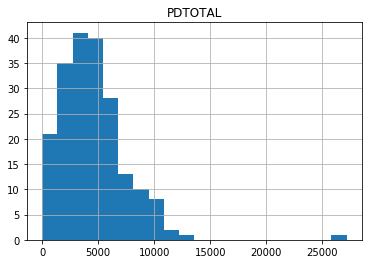

In [91]:
df_geopop.hist(column='PDTOTAL', bins = 20)
# PLEASE EXECUTE TWICE TO HAVE THE DSTRIBUTION SHOWN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120860d10>]],
      dtype=object)

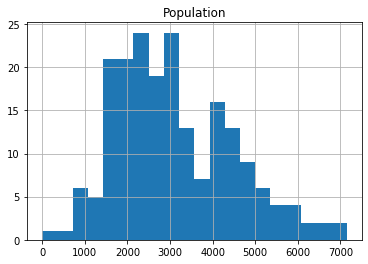

In [92]:
df_geopop.hist(column='Population', bins = 20)

### Given the outlier in the population density plot it seems worthwhile to also look at the actual tract population

In [93]:
# recreate the map of target using Population Density a a measures
map_target = folium.Map(location=[latitude, longitude], zoom_start=12)

# create 'heatmap' for  
mx = df_geopop['Population'].max()
mn = df_geopop['Population'].min()
a = 255.0 / (mx-mn)
c = 0.0


# add markers to map
for lat, lng, clabel, population, pdensity in zip(df_geopop['INTPTLAT'], df_geopop['INTPTLONG'], df_geopop['GEO.display-label'], df_geopop['Population'], df_geopop['PDTOTAL']):
    label = 'Census Tract: {}, Population Density {}'.format(clabel, pdensity)
    label = folium.Popup(label, parse_html=True)
    rcolor = int(a*population)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill=True,
        fill_color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)  

map_target

### Using Foursquare Data

In [25]:
CLIENT_ID = 'MU4OZMN3032OXPGG5JSJSFKLQ0F0JJ4JDITTP4B4FG3J5RB2' # your Foursquare ID
CLIENT_SECRET = 'KXMHI0MF40B3G2A3DCGNGEHHGSJ2BPF2LQNCPE0KCNNKDAB1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MU4OZMN3032OXPGG5JSJSFKLQ0F0JJ4JDITTP4B4FG3J5RB2
CLIENT_SECRET:KXMHI0MF40B3G2A3DCGNGEHHGSJ2BPF2LQNCPE0KCNNKDAB1


In [30]:
pdmax = df_geopop['PDTOTAL'].max() # max population density

latmax = df_geopop[df_geopop.PDTOTAL >= pdmax]['INTPTLAT'].values[0]
lonmax = df_geopop[df_geopop.PDTOTAL >= pdmax]['INTPTLONG'].values[0]
print(latmax)
print(lonmax)

LIMIT = 100
radius = 20000

category = '4bf58dd8d48988d1fd941735,5744ccdfe4b0c0459246b4dc'

# create URL
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latmax, 
    lonmax, 
    radius, 
    LIMIT,
    category)
url # display URL

39.299511200000005
-76.609125


'https://api.foursquare.com/v2/venues/search?&client_id=MU4OZMN3032OXPGG5JSJSFKLQ0F0JJ4JDITTP4B4FG3J5RB2&client_secret=KXMHI0MF40B3G2A3DCGNGEHHGSJ2BPF2LQNCPE0KCNNKDAB1&v=20180605&ll=39.299511200000005,-76.609125&radius=20000&limit=100&categoryId=4bf58dd8d48988d1fd941735,5744ccdfe4b0c0459246b4dc'

In [31]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dd38808660a9f00254e04e4'},
 'response': {'venues': [{'id': '4ad4c019f964a520fff020e3',
    'name': 'The Gallery',
    'location': {'address': '200 E Pratt St',
     'crossStreet': 'at S Calvert St',
     'lat': 39.28700483651814,
     'lng': -76.61182621887333,
     'labeledLatLngs': [{'label': 'display',
       'lat': 39.28700483651814,
       'lng': -76.61182621887333}],
     'distance': 1411,
     'postalCode': '21202',
     'cc': 'US',
     'city': 'Baltimore',
     'state': 'MD',
     'country': 'United States',
     'formattedAddress': ['200 E Pratt St (at S Calvert St)',
      'Baltimore, MD 21202',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1fd941735',
      'name': 'Shopping Mall',
      'pluralName': 'Shopping Malls',
      'shortName': 'Mall',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1574144115',
    'hasP

### Retrieve list of malls from result set 

In [94]:
mall_list = []
for item in results['response']['venues']:
    mall_lat = item['location']['lat']
    mall_lng = item['location']['lng']
    mall_name = item['name']
    mall_id = item['id']
    tup = (mall_lat,mall_lng,mall_name,mall_id,)
    mall_list.append(tup)

vlat = results['response']['venues'][0]['location']['lat']
vlng  = results['response']['venues'][0]['location']['lng']
df_malls = pd.DataFrame(mall_list, columns=['lat','lon','name','id'])

### Create a new map with shopping malls added

In [95]:
# recreate the map of target using Population Density a a measures
map_target = folium.Map(location=[latitude, longitude], zoom_start=12)

# create 'heatmap' for  
mx = df_geopop['Population'].max()
mn = df_geopop['Population'].min()
a = 255.0 / (mx-mn)
c = 0.0


# add census tracts to map
for lat, lng, clabel, population, pdensity in zip(df_geopop['INTPTLAT'], df_geopop['INTPTLONG'], df_geopop['GEO.display-label'], df_geopop['Population'], df_geopop['PDTOTAL']):
    label = 'Census Tract: {}, Population Density {}'.format(clabel, pdensity)
    label = folium.Popup(label, parse_html=True)
    rcolor = int(a*population)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill=True,
        fill_color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)  

# add malls to map
for lat, lng, clabel in zip(df_malls['lat'], df_malls['lon'], df_malls['name']):
    label = 'Mall: {}'.format(clabel)
    label = folium.Popup(label, parse_html=True)
    rcolor = int(a*population)
    folium.features.RegularPolygonMarker(
        [lat, lng],
        numsides=4,
        radius=10,
        rotation=45,
        popup=label,
        color='green',#,#''#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill=True,
        fill_color='green',#'#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)

map_target

In [96]:
df_geopop['PDTOTAL'].max()

27170.540403943472

In [97]:
df_malls.describe()

,lat,lon
count,50.000000,50.000000
mean,39.325763,-76.638263
std,0.097681,0.106006
min,39.138657,-76.819164
25%,39.270886,-76.724522
50%,39.352892,-76.622504
75%,39.400737,-76.586575
max,39.515926,-76.446646


In [98]:
# create the metrics for distance between census tract and mall

In [99]:
# function to calculate the euclidian distance between two geo-locations
def get_distance(t11,t12,t21,t22):
    scale = 111 # number of kilometers corresponding to 1 degree latitude or longitude
    return scale*math.sqrt((t21 - t11)**2 + (t22 - t12)**2)

# sigmoid used as a metric. The further away a mall is from the actual census tract the better
# the better from a development perspective.
# The metric below decribes how 'dangerous' another mall is:
# return 1 if within walking distance
# return 1 / distance^2 if larger than walking distance
# param: slope: allows to finetune the metric  
def distance_metric(s, walking_distance, slope):
    if s <=walking_distance:
        return 1
    else:
        return 1 / (1 + slope*((s-walking_distance)/walking_distance)**2)

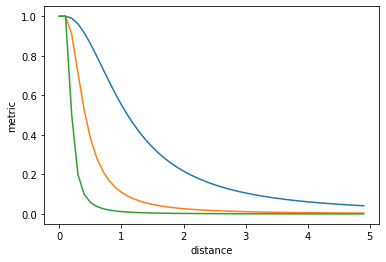

In [100]:
# plot metric
# evenly sampled time at 200ms intervals
s = np.arange(0., 5., 0.1)
m = np.zeros((len(s),3))
for i in range(len(s)):
    m[i,0] = distance_metric(i,1,0.01)
    m[i,1] = distance_metric(i,1,0.1)
    m[i,2] = distance_metric(i,1,1)
    
plt.plot(s, m)
plt.ylabel('metric')
plt.xlabel('distance')
plt.show()

In [254]:
# create a copy for changes further down
df_geomall = df_geopop.copy()

# remove the outlier
_filter = df_geomall.Population > 1
df_geomall = df_geomall[_filter]
df_geomall.shape

(199, 15)

## Preparation of data for analysis
In a first step calculate the distance between each census tract and each mall

In [255]:
# create a dataframe with malls as columns
for i1,i2,i3 in zip(df_malls['lat'],df_malls['lon'],df_malls['id']):
    tup = (i1,i2,None,)
    df_geomall[i3]=0
    
mall_columns = df_malls['id']

In [256]:
# iterate over malls geomall to calculate the distances
for lat, lon, _id in zip(df_malls['lat'], df_malls['lon'],df_malls['id']):
    # df_geomall.loc[:,_id] = get_distance(lat,lon,df_geomall.loc[:,'INTPTLAT'],df_geomall.loc[:,'INTPTLONG'])
    for index, row in df_geomall.iterrows():
        #t1 = (lat,lon)
        #t2 = (row['INTPTLAT'],row['INTPTLONG'])
        dis = get_distance(lat,lon, row['INTPTLAT'],row['INTPTLONG'])
        metric = distance_metric(dis,1.0,0.1) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< change slope here
        #print(_id,dis,metric)
        df_geomall.loc[index,_id] = metric
    
        

In [257]:
df_geomall.describe()

,GEOID,Population,Error,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,XYZ,...,56019a67498e127440beb0d4,4e5662f6d164a0684c5dec43,51c74c8c498ec4d10ab47a40,4e8f3e1ce5fa2c09eadb1bfc,5cf2cabc1af852002cd43a2b,4b649c10f964a520e0c12ae3,4e9b3e9402d5df1b50916619,539b6884498ed490cde201b1,5157759be4b00f5f9a3fb259,5395ce59498eee59c289ff41
count,1.990000e+02,199.000000,199.000000,1.990000e+02,1.990000e+02,199.000000,199.000000,199.000000,199.000000,0.0,...,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,2.451019e+10,3114.552764,384.663317,1.024973e+06,9.637387e+04,0.395764,0.037206,39.311139,-76.618601,NaN,...,0.112003,0.116907,0.117393,0.289587,0.022122,0.150306,0.042744,0.032631,0.019603,0.042795
std,8.203386e+04,1366.872943,170.301640,1.120620e+06,6.117620e+05,0.432675,0.236167,0.030833,0.044091,NaN,...,0.090199,0.141332,0.105211,0.221275,0.009847,0.199462,0.018432,0.019363,0.006518,0.030847
min,2.451001e+10,697.000000,77.000000,1.552440e+05,0.000000e+00,0.060000,0.000000,39.217624,-76.706489,NaN,...,0.025552,0.021943,0.026714,0.043334,0.009087,0.025262,0.014564,0.012062,0.009541,0.013959
25%,2.451012e+10,2066.000000,251.500000,3.879210e+05,0.000000e+00,0.150000,0.000000,39.289710,-76.649295,NaN,...,0.059884,0.047933,0.059099,0.138503,0.014978,0.048565,0.029645,0.019034,0.015264,0.022826
50%,2.451020e+10,2922.000000,357.000000,7.773890e+05,0.000000e+00,0.300000,0.000000,39.307721,-76.616306,NaN,...,0.082780,0.073119,0.080569,0.211441,0.019593,0.081745,0.037056,0.026570,0.017972,0.032535
75%,2.451027e+10,4052.000000,491.000000,1.204164e+06,0.000000e+00,0.465000,0.000000,39.334391,-76.585536,NaN,...,0.119659,0.111658,0.128915,0.361416,0.027213,0.140977,0.051908,0.039971,0.022115,0.049753
max,2.451028e+10,7144.000000,999.000000,1.000742e+07,7.154314e+06,3.864000,2.762000,39.369990,-76.535045,NaN,...,0.578945,0.908855,0.651110,1.000000,0.061671,1.000000,0.106900,0.110515,0.041362,0.204514


In [258]:
#mall_columns = ['51c74c8c498ec4d10ab47a40','4e8f3e1ce5fa2c09eadb1bfc']
df_geomall['Aggregate'] = df_geomall[df_geomall.columns.intersection(mall_columns)].sum(axis=1)

df_geomall.loc[:,'Score'] = df_geomall.loc[:,'Aggregate']/df_geomall.loc[:,'Population']
aggregate_score = df_geomall.Score.max()
df_geomall.loc[:,'Score'] = df_geomall.loc[:,'Score']#/aggregate_score*10
df_geomall.Score.max()

0.009534638428521052

-0.014206420880413158


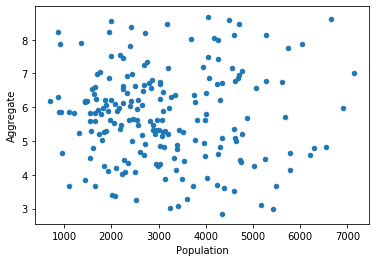

In [259]:
df_geomall.plot.scatter(x='Population',y='Aggregate')
# print the correlation value
print(df_geomall['Population'].corr(df_geomall['Aggregate']))

In [260]:
df_geomall[['Score']].describe()

,Score
count,199.000000
mean,0.002309
std,0.001428
min,0.000553
25%,0.001423
50%,0.001905
75%,0.002867
max,0.009535


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129dfe810>]],
      dtype=object)

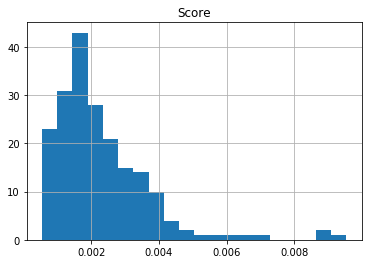

In [261]:
df_geomall.hist(column='Score', bins=20)

In [262]:
df_result = df_geomall.sort_values('Score',ascending=True).head(10)
df_result

,GEOID,GEO.display-label,Population,Error,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,...,51c74c8c498ec4d10ab47a40,4e8f3e1ce5fa2c09eadb1bfc,5cf2cabc1af852002cd43a2b,4b649c10f964a520e0c12ae3,4e9b3e9402d5df1b50916619,539b6884498ed490cde201b1,5157759be4b00f5f9a3fb259,5395ce59498eee59c289ff41,Aggregate,Score
197,24510280403,"Census Tract 2804.03, Baltimore city, Maryland",5431,781,MD,1831350,0,0.707,0.000,39.285991,...,0.033196,0.102435,0.059147,0.174694,0.025667,0.012062,0.011611,0.014023,3.002297,0.000553
128,24510250500,"Census Tract 2505, Baltimore city, Maryland",5171,999,MD,8571196,4070107,3.309,1.571,39.217624,...,0.026714,0.043334,0.017882,0.025262,0.014564,0.022719,0.009541,0.023776,3.120149,0.000603
116,24510250101,"Census Tract 2501.01, Baltimore city, Maryland",4354,491,MD,962778,0,0.372,0.000,39.277114,...,0.031505,0.093603,0.061671,0.138900,0.023751,0.012087,0.011103,0.013959,2.854222,0.000656
103,24510200701,"Census Tract 2007.01, Baltimore city, Maryland",5483,526,MD,1203688,0,0.465,0.000,39.290014,...,0.042527,0.156237,0.042853,0.172724,0.029263,0.014488,0.013031,0.017046,3.678580,0.000671
142,24510260501,"Census Tract 2605.01, Baltimore city, Maryland",5785,761,MD,3217256,3813,1.242,0.001,39.288347,...,0.063463,0.071266,0.011727,0.027950,0.024223,0.062969,0.016622,0.072283,4.130060,0.000714
155,24510270401,"Census Tract 2704.01, Baltimore city, Maryland",6211,675,MD,1457279,0,0.563,0.000,39.346201,...,0.203958,0.112829,0.010325,0.034740,0.046071,0.087628,0.030322,0.138135,4.573126,0.000736
136,24510260302,"Census Tract 2603.02, Baltimore city, Maryland",6557,756,MD,896758,0,0.346,0.000,39.317068,...,0.125401,0.143901,0.012773,0.041061,0.037056,0.056918,0.022001,0.075245,4.833554,0.000737
191,24510280102,"Census Tract 2801.02, Baltimore city, Maryland",6292,727,MD,3497414,1273,1.350,0.000,39.341467,...,0.054559,0.206181,0.032776,0.936361,0.049852,0.013357,0.017147,0.016253,4.801180,0.000763
144,24510260605,"Census Tract 2606.05, Baltimore city, Maryland",4606,615,MD,10007419,7154314,3.864,2.762,39.258378,...,0.042183,0.056202,0.013057,0.025692,0.018974,0.042698,0.012954,0.045531,3.525218,0.000765
133,24510260202,"Census Tract 2602.02, Baltimore city, Maryland",5785,586,MD,1019290,1618,0.394,0.001,39.324894,...,0.142817,0.132836,0.011892,0.038582,0.039035,0.065942,0.023910,0.090722,4.660484,0.000806


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129f68e50>]],
      dtype=object)

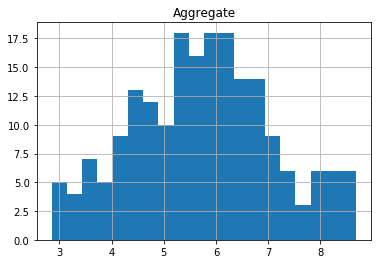

In [263]:
df_geomall.hist(column='Aggregate', bins = 20)

In [264]:
# recreate the map of target using Population Density a a measures
map_target = folium.Map(location=[latitude, longitude], zoom_start=12)

# create 'heatmap' for  
mx = df_geopop['Population'].max()
mn = df_geopop['Population'].min()
a = 255.0 / (mx-mn)
c = 0.0


# add census tracts to map
for lat, lng, clabel, population, pdensity in zip(df_result['INTPTLAT'], df_result['INTPTLONG'], df_result['GEO.display-label'], df_result['Population'], df_result['PDTOTAL']):
    label = 'Census Tract: {}, Population Density {}'.format(clabel, pdensity)
    label = folium.Popup(label, parse_html=True)
    rcolor = int(a*population)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill=True,
        fill_color='#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)  

# add malls to map
for lat, lng, clabel in zip(df_malls['lat'], df_malls['lon'], df_malls['name']):
    label = 'Mall: {}'.format(clabel)
    label = folium.Popup(label, parse_html=True)
    rcolor = int(a*population)
    folium.features.RegularPolygonMarker(
        [lat, lng],
        numsides=4,
        radius=10,
        rotation=45,
        popup=label,
        color='green',#,#''#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill=True,
        fill_color='green',#'#'+hex(rcolor)[2:]+hex(65)[2:]+hex(65)[2:],#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)

    
map_target